In [1]:
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler

import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
# Q(z|X) -- encoder
m = 50
n_z = 2
n_epoch = 10

inputs = Input(shape=(784,))
h_q = Dense(512, activation='relu')(inputs)
mu = Dense(n_z, activation='linear')(h_q)
log_sigma = Dense(n_z, activation='linear')(h_q)

In [3]:
def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0.)
    return mu + K.exp(log_sigma / 2) * eps


# Sample z ~ Q(z|X)
z = Lambda(sample_z)([mu, log_sigma])

In [4]:
# P(X|z) -- decoder
decoder_hidden = Dense(512, activation='relu')
decoder_out = Dense(784, activation='sigmoid')

h_p = decoder_hidden(z)
outputs = decoder_out(h_p)

In [5]:
# Overall VAE model, for reconstruction and training
vae = Model(inputs, outputs)

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder = Model(inputs, mu)

# Generator model, generate new data given latent variable z
d_in = Input(shape=(n_z,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

In [102]:
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 784)           0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 512)           401920                                       
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 2)             1026                                         
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 2)             1026                                         
___________________________________________________________________________________________

In [6]:
def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)

    return recon + kl

In [7]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [8]:
train_data = mnist.train.images
train_labels = mnist.train.labels

In [9]:
vae.compile(optimizer='adam', loss=vae_loss)
vae.fit(train_data, train_data, batch_size=m, epoch=n_epoch)

/Users/bnjasim/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Epoch 1/10
55000/55000 [==============================] - 32s - loss: 181.9550    
Epoch 2/10
55000/55000 [==============================] - 30s - loss: 165.6199    
Epoch 3/10
55000/55000 [==============================] - 30s - loss: 162.4806    
Epoch 4/10
55000/55000 [==============================] - 29s - loss: 160.1067    
Epoch 5/10
55000/55000 [==============================] - 28s - loss: 158.4558    
Epoch 6/10
55000/55000 [==============================] - 28s - loss: 157.2540    
Epoch 7/10
55000/55000 [==============================] - 31s - loss: 156.3759    
Epoch 8/10
55000/55000 [==============================] - 30s - loss: 155.5854    
Epoch 9/10
55000/55000 [==============================] - 29s - loss: 154.9633    
Epoch 10/10
55000/55000 [==============================] - 30s - loss: 154.3815    


### Recreate a Digit

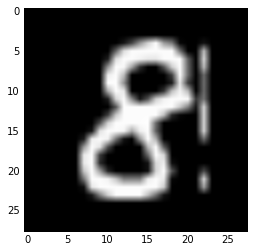

In [109]:
x = train_data[9]
plt.imshow(x.reshape(28,28), cmap='gray', vmin=0, vmax=1)
plt.show()

[[-0.28664362 -0.32963979]]


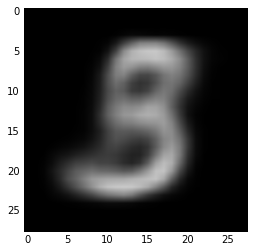

In [111]:
z_latent = encoder.predict(x.reshape(1,784))
print z_latent
pred = decoder.predict(z_latent)

plt.imshow(pred.reshape(28,28), cmap='gray', vmin=0, vmax=1)
plt.show()

## Plot the latent space

In [91]:
labels = np.where(train_labels==1.0)[1]

In [119]:
zeros_data = train_data[labels == 0]
ones_data = train_data[labels == 1]
twos_data = train_data[labels == 2]
threes_data = train_data[labels == 3]
fours_data = train_data[labels == 4]
fives_data = train_data[labels == 5]
sixes_data = train_data[labels == 6]
sevens_data = train_data[labels == 7]
eights_data = train_data[labels == 8]
nines_data = train_data[labels == 9]

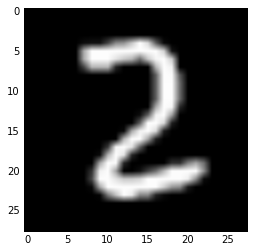

In [106]:
# Cross check the splitting of train_data
x = twos_data[1000]
plt.imshow(x.reshape(28,28), cmap='gray', vmin=0, vmax=1)
plt.show()

In [120]:
# Obtain the latent representations
z_zeros = encoder.predict(zeros_data)
z_ones = encoder.predict(ones_data)
z_twos = encoder.predict(twos_data)
z_threes = encoder.predict(threes_data)
z_fours = encoder.predict(fours_data)
z_fives = encoder.predict(fives_data)
z_sixes = encoder.predict(sixes_data)
z_sevens = encoder.predict(sevens_data)
z_eights = encoder.predict(eights_data)
z_nines = encoder.predict(nines_data)

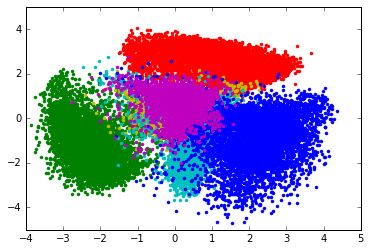

In [130]:
plt.plot(z_zeros[:,0], z_zeros[:,1], '.g')
plt.plot(z_ones[:,0], z_ones[:,1], '.r')
#plt.plot(z_twos[:,0], z_twos[:,1], '.b')
plt.plot(z_threes[:,0], z_threes[:,1], '.y')
plt.plot(z_fours[:,0], z_fours[:,1], '.c')
#plt.plot(z_fives[:,0], z_fives[:,1], '.y')
# plt.plot(z_sixes[:,0], z_sixes[:,1], '.y')
plt.plot(z_sevens[:,0], z_sevens[:,1], '.b')
plt.plot(z_eights[:,0], z_eights[:,1], '.m')

plt.show()

## Generate New Digits

[[ 0.32652106  0.16187989]]


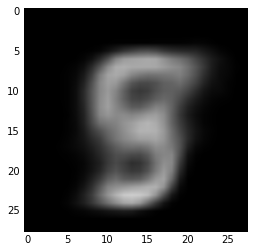

In [101]:
# sample from z
z = np.array([np.random.normal(), np.random.normal()]).reshape([1,2])
print z
pred = decoder.predict(z)

plt.imshow(pred.reshape(28,28), cmap='gray', vmin=0, vmax=1)
plt.show()

In [ ]:
z = 
